<a href="https://colab.research.google.com/github/tsjendoll/TensorFlow---Titanic/blob/main/TensorFlow_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a model that predicts whether or not a passenger survived the Titanic disaster.

In [34]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Here we load the data into a csv file.  There are two datasets provided.  The 'train' dataset is what we will use to train our model.  The 'eval' dataset is what we will be using to make our predictions.  We seperate the 'survived' column from the 'both' datasets to ensure our model works correctly.

In [35]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

Analyze the first 5 rows of the data.  Based on your intuition, what columns(features) do you think will good indicators or survival?

In [38]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Shape of the entire training data.  (627 rows, 9 columns) A small dataset.

In [39]:
dftrain.shape

(627, 9)

Identify the categorical and numeric columns in the data.  Create a list of the features as tensorflow objects.

In [36]:
CATEGORICAL_COLUMNS = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
NUMERICAL_COLUMNS = ['age','fare']
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERICAL_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [37]:
print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

# **Create some histograms and bar graphs to get a better understanding of the data**

# Histogram showing the distribution of ages

Text(0.5, 0, 'Age')

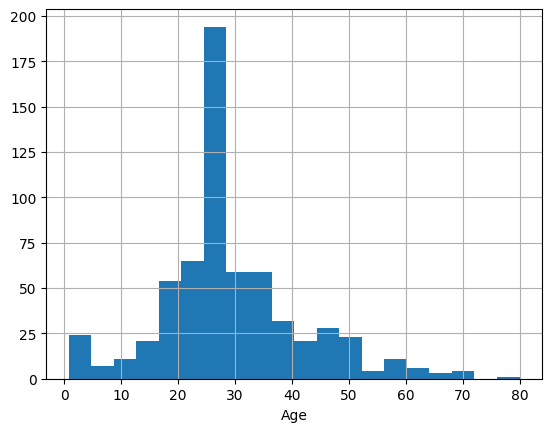

In [47]:
dftrain.age.hist(bins=20).set_xlabel("Age")

# Bar graph male vs. female

<Axes: >

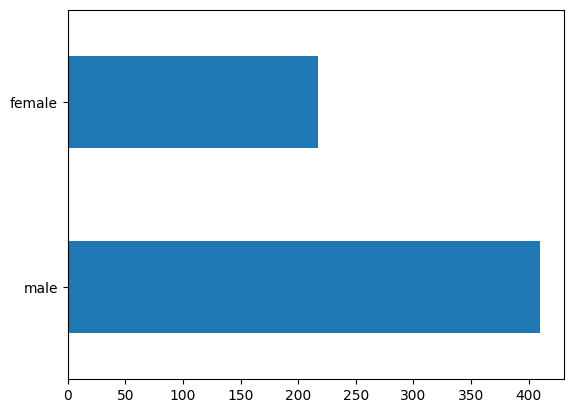

In [41]:
dftrain.sex.value_counts().plot(kind='barh')

# Bar graph showing no. of passengers in each class

<Axes: >

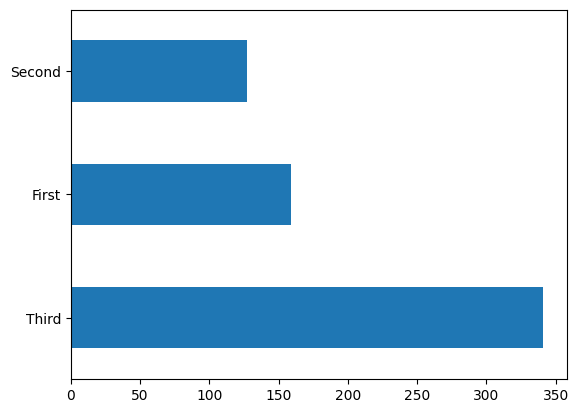

In [42]:
dftrain['class'].value_counts().plot(kind='barh')

# Survival rate for each sex
**Here we can see that being a female is a good indicator of survival**

Text(0.5, 0, '% survive')

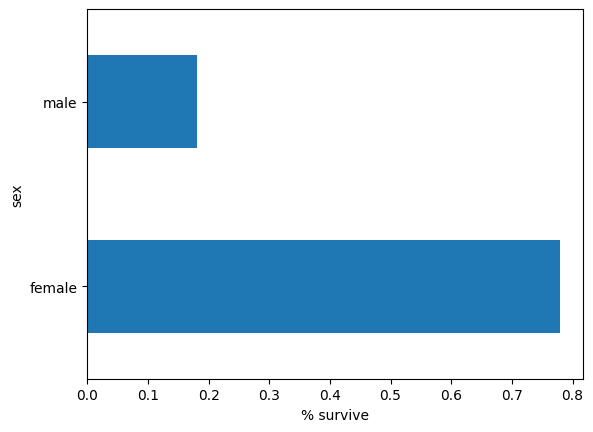

In [43]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

# The survival rate for each class
**Being first class is a fairly good indicator of survival**

Text(0.5, 0, '% survive')

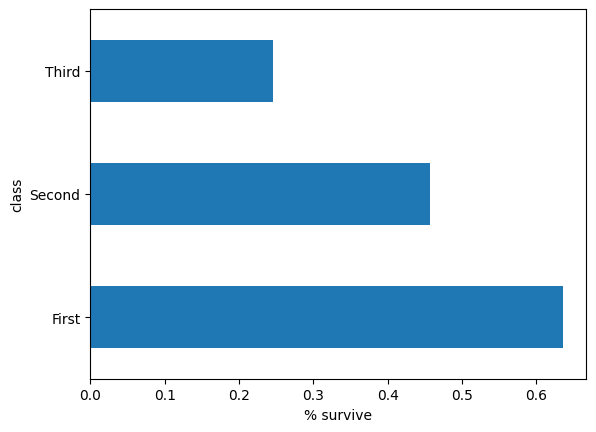

In [44]:
pd.concat([dftrain, y_train], axis=1).groupby('class').survived.mean().plot(kind='barh').set_xlabel('% survive')

Implement a boiler plate make_input function from TensorFlow.  Creates a DataSet object required by TF.

In [45]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create tf.data.Dataset object with data and its label
    if shuffle:
      ds.shuffle(1000) # randomize order data
    ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches batch_size of and repeat process for num_epochs
    return ds # return a batch of the dataset
  return input_function # return a function object for use

In [46]:
train_input_fn = make_input_fn(dftrain, y_train) # call the input_function that was returned to us to get a dataset object we can
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)